In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import matplotlib.pyplot as plt
# Charger le jeu de données

df = pd.read_csv('dataset_test2.csv')

# Sélectionner les variables indépendantes et la variable cible
X = df.drop('MIS_Status', axis=1)
y = df['MIS_Status']

# Encoder la variable cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Identifier les variables catégorielles et numériques
cat_vars = X.select_dtypes(include=['object']).columns.tolist() + ['NewExist'] + ['UrbanRural'] + ['FranchiseBinary'] 
num_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_vars.remove('NewExist')  
num_vars.remove('UrbanRural') 
num_vars.remove('FranchiseBinary') 
# Créer les transformateurs pour les pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combiner les transformateurs dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

# Créer la pipeline de traitement et de modélisation
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('classifier', lgb.LGBMClassifier())
])

# Séparer les données en ensembles d'entraînement et de test, stratifier sur y
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


rf_pipeline.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = rf_pipeline.predict(X_test)


# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(report)


[LightGBM] [Info] Number of positive: 437765, number of negative: 111204
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 548969, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797431 -> initscore=1.370316
[LightGBM] [Info] Start training from score 1.370316
              precision    recall  f1-score   support

      CHGOFF       0.89      0.84      0.87     27801
       P I F       0.96      0.97      0.97    109442

    accuracy                           0.95    137243
   macro avg       0.93      0.91      0.92    137243
weighted avg       0.95      0.95      0.95    137243



In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import lightgbm as lgb

# Charger le jeu de données

df = pd.read_csv('dataset_test2.csv')

# Sélectionner les variables indépendantes et la variable cible
X = df.drop('MIS_Status', axis=1)
y = df['MIS_Status']

# Encoder la variable cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Identifier les variables catégorielles et numériques
cat_vars = X.select_dtypes(include=['object']).columns.tolist()
num_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Créer les transformateurs pour les pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combiner les transformateurs dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])



# Créer la pipeline de traitement et de modélisation
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('classifier', lgb.LGBMClassifier())])

# Séparer les données en ensembles d'entraînement et de test, stratifier sur y
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, shuffle=True, test_size=0.05, random_state=42, stratify=y_encoded)

param_grid = {
    'classifier__num_leaves': [20, 30],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__min_child_samples': [20, 30],
    'classifier__subsample': [0.6, 1.0],
    'classifier__colsample_bytree': [0.6, 1.0],
}

# rf_pipeline.fit(X_train, y_train)

# # Prédire les étiquettes sur l'ensemble de test
# y_pred = rf_pipeline.predict(X_test)


# Créer une instance de GridSearchCV
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy')

# Effectuer la recherche sur la grille
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres trouvés
best_params = grid_search.best_params_

# Meilleur score obtenu sur l'ensemble d'entraînement
best_score = grid_search.best_score_

# Meilleur modèle
best_model = grid_search.best_estimator_

# Utiliser le meilleur modèle pour prédire les étiquettes sur l'ensemble de test
y_pred = best_model.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print("Meilleurs hyperparamètres:", best_params)
print("Meilleur score sur l'ensemble d'entraînement:", best_score)
print("Rapport de classification:")
print(report)

[LightGBM] [Info] Number of positive: 394236, number of negative: 100812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2018
[LightGBM] [Info] Number of data points in the train set: 495048, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796359 -> initscore=1.363692
[LightGBM] [Info] Start training from score 1.363692
[LightGBM] [Info] Number of positive: 394236, number of negative: 100812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2022
[LightGBM] [Info] Number of data points in the train set: 495048, number of used features: 119
[LightGBM] [

KeyboardInterrupt: 

In [19]:
lgb.LGBMClassifier?

Init signature:
lgb.LGBMClassifier(
    boosting_type: str = 'gbdt',
    num_leaves: int = 31,
    max_depth: int = -1,
    learning_rate: float = 0.1,
    n_estimators: int = 100,
    subsample_for_bin: int = 200000,
    objective: Union[str, Callable[[Optional[numpy.ndarray], numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray], Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = None,
    class_weight: Union[Dict, str, NoneType] = None,
    min_split_gain: float = 0.0,
    min_child_weight: float = 0.001,
    min_child_samples: int = 20,
    subsample: float = 1.0,
    subsample_freq: int = 0,
    colsample_bytree: float = 1.0,
    reg_alpha: float = 0.0,
    reg_lambda: float = 0.0,
    random_state: Union[int, numpy.random.mtrand.RandomState, ForwardRef('np.random.Generat

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from catboost import CatBoostClassifier

# Charger le jeu de données

df = pd.read_csv('dataset_test2.csv')

# Sélectionner les variables indépendantes et la variable cible
X = df.drop('MIS_Status', axis=1)
y = df['MIS_Status']


# Identifier les variables catégorielles et numériques
cat_vars = X.select_dtypes(include=['object']).columns.tolist() + ['NewExist'] + ['UrbanRural'] + ['FranchiseBinary'] 
num_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_vars.remove('NewExist')  
num_vars.remove('UrbanRural') 
num_vars.remove('FranchiseBinary') 


# Créer les transformateurs pour les pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

# Combiner les transformateurs dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

# Créer la pipeline de traitement et de modélisation
catboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('classifier', CatBoostClassifier(max_depth=10, one_hot_max_size=10))
])

# Séparer les données en ensembles d'entraînement et de test, stratifier sur y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=0.05, random_state=42, stratify=y)

catboost_pipeline.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = catboost_pipeline.predict(X_test)

# param_grid = {
#     'num_leaves': [20, 30, 40],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [0.001, 0.05, 0.01]
# }
# # Créer une instance de GridSearchCV
# grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy')

# # Effectuer la recherche sur la grille
# grid_search.fit(X_train, y_train)

# # Meilleurs hyperparamètres trouvés
# best_params = grid_search.best_params_

# # Meilleur score obtenu sur l'ensemble d'entraînement
# best_score = grid_search.best_score_

# # Meilleur modèle
# best_model = grid_search.best_estimator_

# # Utiliser le meilleur modèle pour prédire les étiquettes sur l'ensemble de test
# y_pred = best_model.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# print("Meilleurs hyperparamètres:", best_params)
# print("Meilleur score sur l'ensemble d'entraînement:", best_score)
# print("Rapport de classification:")
print(report)

Learning rate set to 0.163904
0:	learn: 0.5133029	total: 378ms	remaining: 6m 17s
1:	learn: 0.4105906	total: 749ms	remaining: 6m 13s
2:	learn: 0.3491371	total: 1.08s	remaining: 5m 57s
3:	learn: 0.3135733	total: 1.32s	remaining: 5m 28s
4:	learn: 0.2853640	total: 1.6s	remaining: 5m 18s
5:	learn: 0.2609983	total: 1.88s	remaining: 5m 11s
6:	learn: 0.2431547	total: 2.16s	remaining: 5m 6s
7:	learn: 0.2328906	total: 2.39s	remaining: 4m 56s
8:	learn: 0.2258380	total: 2.64s	remaining: 4m 50s
9:	learn: 0.2197624	total: 2.89s	remaining: 4m 46s
10:	learn: 0.2139795	total: 3.16s	remaining: 4m 43s
11:	learn: 0.2076103	total: 3.44s	remaining: 4m 43s
12:	learn: 0.2041205	total: 3.72s	remaining: 4m 42s
13:	learn: 0.2011688	total: 3.98s	remaining: 4m 40s
14:	learn: 0.1985291	total: 4.27s	remaining: 4m 40s
15:	learn: 0.1944664	total: 4.55s	remaining: 4m 39s
16:	learn: 0.1911155	total: 4.83s	remaining: 4m 39s
17:	learn: 0.1889843	total: 5.05s	remaining: 4m 35s
18:	learn: 0.1865982	total: 5.29s	remaining: 4

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# On crée la matrice de confusion en passant les classes et les prédictions du modèle, puis on l'affiche
y_train_pred_cat = cross_val_predict(catboost_pipeline, X_train, y_train)
cm = confusion_matrix(y_train, y_train_pred_cat)
display(cm)



Learning rate set to 0.149008
0:	learn: 0.5258156	total: 99ms	remaining: 1m 38s
1:	learn: 0.4275702	total: 197ms	remaining: 1m 38s
2:	learn: 0.3595619	total: 299ms	remaining: 1m 39s
3:	learn: 0.3146526	total: 396ms	remaining: 1m 38s
4:	learn: 0.2914315	total: 485ms	remaining: 1m 36s
5:	learn: 0.2723684	total: 585ms	remaining: 1m 36s
6:	learn: 0.2555552	total: 687ms	remaining: 1m 37s
7:	learn: 0.2449120	total: 785ms	remaining: 1m 37s
8:	learn: 0.2367658	total: 877ms	remaining: 1m 36s
9:	learn: 0.2305051	total: 973ms	remaining: 1m 36s
10:	learn: 0.2236396	total: 1.06s	remaining: 1m 35s
11:	learn: 0.2149944	total: 1.15s	remaining: 1m 34s
12:	learn: 0.2106634	total: 1.24s	remaining: 1m 34s
13:	learn: 0.2070814	total: 1.34s	remaining: 1m 34s
14:	learn: 0.2032672	total: 1.44s	remaining: 1m 34s
15:	learn: 0.2011847	total: 1.56s	remaining: 1m 36s
16:	learn: 0.1985610	total: 1.66s	remaining: 1m 35s
17:	learn: 0.1964792	total: 1.75s	remaining: 1m 35s
18:	learn: 0.1915291	total: 1.85s	remaining: 

/home/utilisateur/Documents/Projets/Machine-learning/brief_classif_sba/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.149008
0:	learn: 0.5268607	total: 109ms	remaining: 1m 48s
1:	learn: 0.4269820	total: 221ms	remaining: 1m 50s
2:	learn: 0.3681616	total: 318ms	remaining: 1m 45s
3:	learn: 0.3268981	total: 417ms	remaining: 1m 43s
4:	learn: 0.3002497	total: 527ms	remaining: 1m 44s
5:	learn: 0.2817856	total: 623ms	remaining: 1m 43s
6:	learn: 0.2573488	total: 725ms	remaining: 1m 42s
7:	learn: 0.2462725	total: 814ms	remaining: 1m 40s
8:	learn: 0.2380101	total: 906ms	remaining: 1m 39s
9:	learn: 0.2280518	total: 1s	remaining: 1m 39s
10:	learn: 0.2231006	total: 1.1s	remaining: 1m 39s
11:	learn: 0.2143295	total: 1.2s	remaining: 1m 38s
12:	learn: 0.2105775	total: 1.29s	remaining: 1m 38s
13:	learn: 0.2044587	total: 1.39s	remaining: 1m 38s
14:	learn: 0.2017606	total: 1.49s	remaining: 1m 38s
15:	learn: 0.1984549	total: 1.59s	remaining: 1m 38s
16:	learn: 0.1960099	total: 1.7s	remaining: 1m 38s
17:	learn: 0.1939983	total: 1.79s	remaining: 1m 37s
18:	learn: 0.1920979	total: 1.89s	remaining: 1m 37

array([[116144,  15911],
       [ 12994, 506852]])

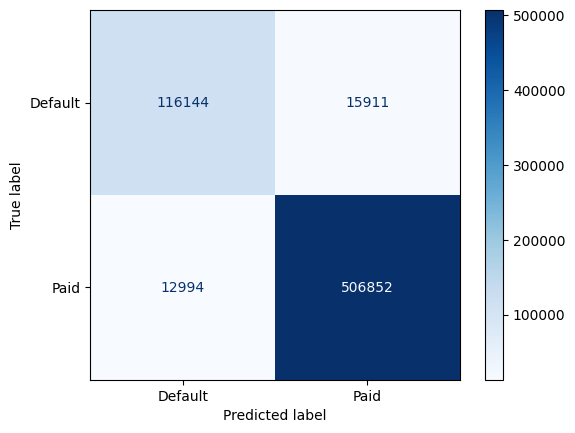

In [65]:
# Affichage avec un plot
graph_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Default", "Paid"])
graph_cm.plot(cmap="Blues")

In [5]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_predict

# Au lieu d'obtenir les prédictions, on récupere les scores de probabilités pour chaque observations
y_probas_cat = cross_val_predict(catboost_pipeline, X_train, y_train, method="predict_proba")
display(y_probas_cat)

# On récupere uniquement les probabilités pour la classe positive
y_scores_cat = y_probas_cat[:, 1]

# A partir des probabilités on calcule les combinaisons de scores pour recall et precision en fonction du seuil
precisions_cat, recalls_cat, thresholds_cat = precision_recall_curve(y_train, y_scores_cat)

Learning rate set to 0.149008
0:	learn: 0.5255308	total: 300ms	remaining: 4m 59s
1:	learn: 0.4266843	total: 570ms	remaining: 4m 44s
2:	learn: 0.3591964	total: 866ms	remaining: 4m 47s
3:	learn: 0.3200147	total: 1.06s	remaining: 4m 25s
4:	learn: 0.2879499	total: 1.28s	remaining: 4m 14s
5:	learn: 0.2706185	total: 1.46s	remaining: 4m 2s
6:	learn: 0.2554469	total: 1.65s	remaining: 3m 53s
7:	learn: 0.2452866	total: 1.85s	remaining: 3m 49s
8:	learn: 0.2355867	total: 2.04s	remaining: 3m 45s
9:	learn: 0.2296170	total: 2.25s	remaining: 3m 42s
10:	learn: 0.2202703	total: 2.5s	remaining: 3m 44s
11:	learn: 0.2132522	total: 2.79s	remaining: 3m 49s
12:	learn: 0.2084120	total: 3.04s	remaining: 3m 50s
13:	learn: 0.2050314	total: 3.24s	remaining: 3m 48s
14:	learn: 0.2024214	total: 3.44s	remaining: 3m 46s
15:	learn: 0.1987115	total: 3.66s	remaining: 3m 44s
16:	learn: 0.1969163	total: 3.94s	remaining: 3m 47s
17:	learn: 0.1937762	total: 4.14s	remaining: 3m 45s
18:	learn: 0.1920942	total: 4.34s	remaining: 3

/home/melody/Documents/Projects/Classification-brief/brief_classif_sba/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.149008
0:	learn: 0.5226098	total: 215ms	remaining: 3m 34s
1:	learn: 0.4253277	total: 438ms	remaining: 3m 38s
2:	learn: 0.3583489	total: 709ms	remaining: 3m 55s
3:	learn: 0.3133580	total: 923ms	remaining: 3m 49s
4:	learn: 0.2917418	total: 1.16s	remaining: 3m 50s
5:	learn: 0.2724626	total: 1.37s	remaining: 3m 47s
6:	learn: 0.2524285	total: 1.6s	remaining: 3m 47s
7:	learn: 0.2419028	total: 1.8s	remaining: 3m 43s
8:	learn: 0.2313854	total: 2.13s	remaining: 3m 54s
9:	learn: 0.2243781	total: 2.37s	remaining: 3m 54s
10:	learn: 0.2186558	total: 2.66s	remaining: 3m 59s
11:	learn: 0.2141134	total: 2.89s	remaining: 3m 58s
12:	learn: 0.2100277	total: 3.13s	remaining: 3m 57s
13:	learn: 0.2072236	total: 3.35s	remaining: 3m 55s
14:	learn: 0.2031802	total: 3.6s	remaining: 3m 56s
15:	learn: 0.2000097	total: 3.81s	remaining: 3m 54s
16:	learn: 0.1962160	total: 4.02s	remaining: 3m 52s
17:	learn: 0.1927768	total: 4.24s	remaining: 3m 51s
18:	learn: 0.1908606	total: 4.49s	remaining: 3m

array([[0.99806331, 0.00193669],
       [0.99578068, 0.00421932],
       [0.98460837, 0.01539163],
       ...,
       [0.98592463, 0.01407537],
       [0.99464787, 0.00535213],
       [0.02397172, 0.97602828]])

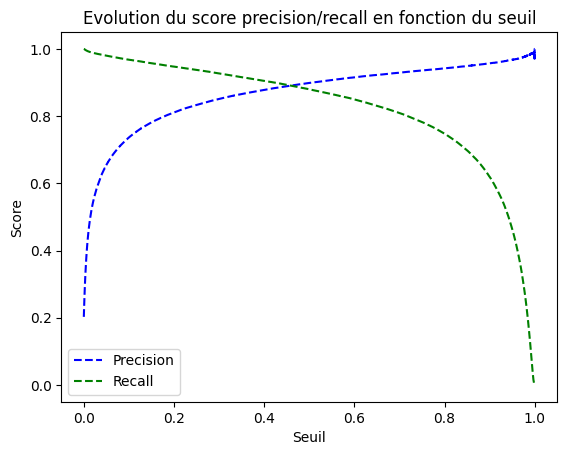

In [6]:
import matplotlib.pyplot as plt

plt.plot(thresholds_cat, precisions_cat[:-1], "b--", label="Precision")
plt.plot(thresholds_cat, recalls_cat[:-1], "g--", label="Recall")
plt.title("Evolution du score precision/recall en fonction du seuil")
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.legend()
plt.show()

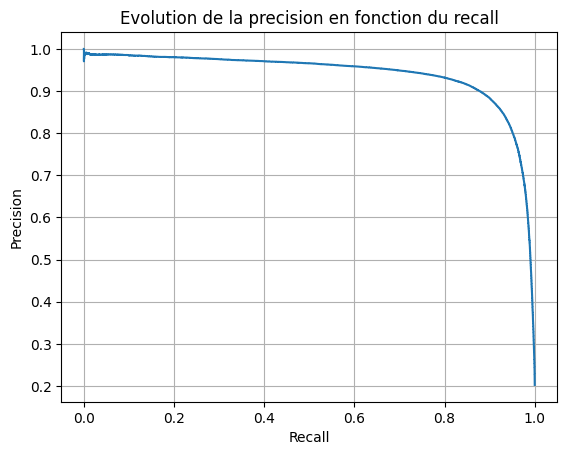

0.9405133913391643

In [7]:
from sklearn.metrics import average_precision_score

plt.plot(recalls_cat[:-1], precisions_cat[:-1])

plt.title("Evolution de la precision en fonction du recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

auc_pr = average_precision_score(y_train, y_scores_cat)
display(auc_pr)

In [8]:
from sklearn.metrics import roc_curve

# La fonction roc_curve retourne le FPR, TPR et les seuils 
fpr_cat, tpr_cat, tresholds_cat = roc_curve(y_train, y_scores_cat)

In [9]:
# Fonction pour représenter la courbe ROC
def plot_roc_curve(fpr, tpr, label=None):

    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.title("Courbe ROC")
    plt.xlabel("Taux de Faux Positif")
    plt.ylabel("Taux de Vrai Positif")
    plt.grid()

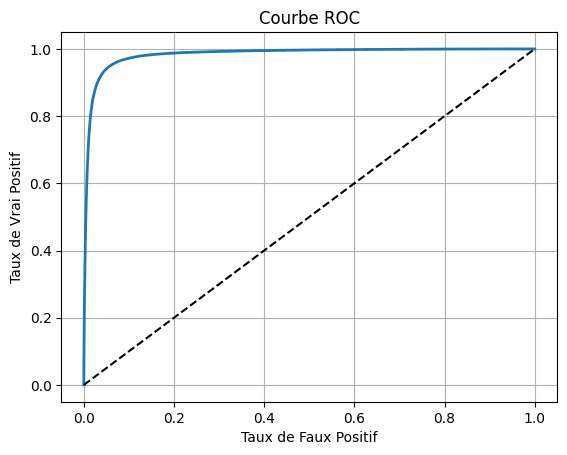

In [10]:
plot_roc_curve(fpr_cat, tpr_cat)
plt.show()

In [11]:
from sklearn.metrics import roc_auc_score

display(roc_auc_score(y_train, y_scores_cat))

0.9837052441317594

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


# Charger le jeu de données

df = pd.read_csv('dataset_test2.csv')

# Sélectionner les variables indépendantes et la variable cible
X = df.drop('MIS_Status', axis=1)
y = df['MIS_Status']

# Encoder la variable cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Identifier les variables catégorielles et numériques
cat_vars = X.select_dtypes(include=['object']).columns.tolist() + ['NewExist'] + ['UrbanRural'] + ['FranchiseBinary'] 
num_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_vars.remove('NewExist')  
num_vars.remove('UrbanRural') 
num_vars.remove('FranchiseBinary') 

# Créer les transformateurs pour les pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combiner les transformateurs dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

# Créer la pipeline de traitement et de modélisation
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('classifier', GaussianNB())
])

# Séparer les données en ensembles d'entraînement et de test, stratifier sur y
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, shuffle=True, test_size=0.05, random_state=42, stratify=y_encoded)

rf_pipeline.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = rf_pipeline.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(report)

              precision    recall  f1-score   support

      CHGOFF       0.25      0.88      0.38      6950
       P I F       0.91      0.31      0.47     27361

    accuracy                           0.43     34311
   macro avg       0.58      0.60      0.43     34311
weighted avg       0.78      0.43      0.45     34311



In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


# Charger le jeu de données

df = pd.read_csv('dataset_test2.csv')

# Sélectionner les variables indépendantes et la variable cible
X = df.drop('MIS_Status', axis=1)
y = df['MIS_Status']

# Encoder la variable cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Identifier les variables catégorielles et numériques
cat_vars = X.select_dtypes(include=['object']).columns.tolist() + ['NewExist'] + ['UrbanRural'] + ['FranchiseBinary'] 
num_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_vars.remove('NewExist')  
num_vars.remove('UrbanRural') 
num_vars.remove('FranchiseBinary') 
# Créer les transformateurs pour les pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combiner les transformateurs dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

# Créer la pipeline de traitement et de modélisation
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('classifier', BernoulliNB())
])

# Séparer les données en ensembles d'entraînement et de test, stratifier sur y
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, shuffle=True, test_size=0.05, random_state=42, stratify=y_encoded)

rf_pipeline.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = rf_pipeline.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(report)

              precision    recall  f1-score   support

      CHGOFF       0.37      0.62      0.46      6950
       P I F       0.88      0.73      0.80     27361

    accuracy                           0.71     34311
   macro avg       0.63      0.67      0.63     34311
weighted avg       0.78      0.71      0.73     34311



In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


# Charger le jeu de données

df = pd.read_csv('dataset_test2.csv')

# Sélectionner les variables indépendantes et la variable cible
X = df.drop('MIS_Status', axis=1)
y = df['MIS_Status']

# Encoder la variable cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Identifier les variables catégorielles et numériques
cat_vars = X.select_dtypes(include=['object']).columns.tolist() + ['NewExist'] + ['UrbanRural'] + ['FranchiseBinary'] 
num_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_vars.remove('NewExist')  
num_vars.remove('UrbanRural') 
num_vars.remove('FranchiseBinary') 

# Créer les transformateurs pour les pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combiner les transformateurs dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

# Créer la pipeline de traitement et de modélisation
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('classifier', LogisticRegression(random_state=42))
])

# Séparer les données en ensembles d'entraînement et de test, stratifier sur y
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, shuffle=True, test_size=0.05, random_state=42, stratify=y_encoded)

rf_pipeline.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = rf_pipeline.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(report)

              precision    recall  f1-score   support

      CHGOFF       0.73      0.42      0.53      6950
       P I F       0.87      0.96      0.91     27361

    accuracy                           0.85     34311
   macro avg       0.80      0.69      0.72     34311
weighted avg       0.84      0.85      0.83     34311

